In [1]:
%pip install mlflow

import plotly.express as px
import pandas as pd
import mlflow
import pandas.core.series
import sklearn.tree
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.5/147.5 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00
  Created wheel for databricks-cli: filename=databricks_cli-0.17.6-py3-none-any.whl size=143237 sha256=b35a5fd83d0d71ccc840902552fd277c285408851892864b06de054546fac52c
  Stored in directory: /root/.cache/pip/wheels

Cloning the Github-repository containing all relevant data-files and the tuned ML-Model

In [2]:
!git clone https://github.com/TienDeeLInPrivate/DataExplorationR6

Cloning into 'DataExplorationR6'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 58 (delta 0), reused 52 (delta 0), pack-reused 5
Unpacking objects: 100% (58/58), 2.61 MiB | 1.11 MiB/s, done.


Optional command to pull the most recent version of the repo

In [3]:
%cd /content/DataExplorationR6/
!git pull

/content/DataExplorationR6
Already up to date.


Reading file containing data used for training. This version is in a format not ready for training but suitable for general visualizations. 

This project only considers all Rainbow Six Siege games played in Year 2 Season 5, on PC and where the players of each game were around the highest rank of the game ("Diamond").

In [3]:
filename = "/content/DataExplorationR6/R6ProcessedData/Preprocessing1Result.csv"
df = pd.read_csv(filename, index_col=None, header=0)
#print(df.head(10))

Visualization showing how often each map has been played sorted descending from left to right. The map is randomly asigned by the game, players are unable to influence which map is being played.

In [4]:
df_mapname = df[['mapname']]

df_mapname = df_mapname.groupby('mapname').size()
df_mapname = df_mapname.reset_index(name='times_played')
df_mapname = df_mapname.sort_values('times_played', ascending=False)

fig = px.bar(df_mapname, x="mapname", y="times_played",title="Maps played in Season 5 Diamond Rank")
fig.update_traces(marker_color='green')
fig.show()




Visualization showing how often each operator has been picked sorted descending from left to right. Every game consists of 5 attacking operators vs 5 defending operators. The Chart shows that there are operators with high, medium and low popularity. The most picked operators are "Ash" and "Jager". "Ash" had the strongest primary weapon on the attacking side in the game and "Jaeger" had the strongest ability on the defending side.   

In [5]:
df_operator = df[['operator']]

df_operator = df_operator.groupby('operator').size()
df_operator = df_operator.reset_index(name='times_picked')
df_operator = df_operator.sort_values('times_picked', ascending=False)

df_operator = df_operator[~df_operator['operator'].str.contains('RESERVE')]
fig = px.bar(df_operator, x="operator", y="times_picked", title="Operators picked in Season 5 Diamond Rank")
fig.update_traces(marker_color='red')
fig.show()

Scatterplot showing how often a picked operator wins vs how often the operator is picked.

In [6]:
df_winrate = df[['operator', 'haswon','matchid', 'roundnumber']]

df_role = df[['operator', 'role']]
df_winrate['realMatchID'] = df_winrate['matchid'].astype(str) + "-" + df_winrate['roundnumber'].astype(str)

# Credit: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nunique.html
total_number_games = df_winrate['realMatchID'].nunique()

df_winrate = df_winrate[df_winrate['haswon'] == 1]
df_winrate = df_winrate.groupby(['operator'])['haswon'].count()


df_winrate = df_winrate.reset_index(name='winrate')
df_winrate = pd.merge(df_winrate, df_operator, on='operator')

df_winrate['winrate'] = (df_winrate['winrate']/df_winrate['times_picked']) * 100


df_winrate_pickrate = df_winrate
df_winrate_pickrate["pickrate"] = (df_winrate_pickrate["times_picked"] / total_number_games) * 100
df_winrate_pickrate = pd.merge(df_winrate_pickrate, df_role,on='operator', how='left')
df_winrate_pickrate = df_winrate_pickrate.drop_duplicates()
df_winrate_pickrate = df_winrate_pickrate.reset_index(drop=True)

df_winrate_pickrate = df_winrate_pickrate[~df_winrate_pickrate['operator'].str.contains('RESERVE')]
df_winrate_pickrate['operator'] = df_winrate_pickrate['operator'].str.split('-', n=1)
df_winrate_pickrate['operator'] = df_winrate_pickrate['operator'].str[1]

winrate_pickrate_scatterplot = px.scatter(df_winrate_pickrate, x="winrate", y="pickrate", text="operator", color="role", title="Winrate vs Pickrate of all Operators (in %)")
winrate_pickrate_scatterplot.update_traces(textposition='top center')

winrate_pickrate_scatterplot.update_layout(yaxis=dict(range=[0, 100], tickvals=[0, 25, 50, 75, 100])) 
winrate_pickrate_scatterplot = winrate_pickrate_scatterplot.update_layout(height=900, width=1000) 
winrate_pickrate_scatterplot.show()

<ipython-input-6-978db1f6d9d1>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



The chart shows that beyond "good" operators being popular and "bad" operators being unpopular, there are many operators with an above-average winrate, whose potential is not recognized or realized by many players.

The data read hier is the complete data used for training the ML-Model. It is being read so the imported optimal Model can be scored on its validation and testing accuracy.

In [7]:
filename = "/content/DataExplorationR6/R6ProcessedData/mainResultEncoded.csv"
df = pd.read_csv(filename, index_col=None, header=0)

This function splits data into 70% training, 20% validation and 10% testing data

In [14]:
def split_train_val_test(df_encoded:pd.core.frame.DataFrame) -> tuple[pandas.core.frame.DataFrame, pandas.core.series.Series, pandas.core.frame.DataFrame, pandas.core.series.Series, pandas.core.frame.DataFrame, pandas.core.series.Series]:
  """
  Function to split data into 70% training, 20% validation and 10% testing.

  Parameters
  ----------
  df_encoded : pd.core.frame.DataFrame
      Return value from one_hot_encode().

  Returns
  -------
  features_train : pd.core.frame.DataFrame
      Dataframe containing all features for training.
  labels_train : pandas.core.series.Series
      Series containing all labels for training.
  features_validation : pd.core.frame.DataFrame
      Dataframe containing all features for validation.
  labels_validation : pandas.core.series.Series
      Series containing all labels for validation.
  features_test : pd.core.frame.DataFrame
      Dataframe containing all features for testing.
  labels_test : pandas.core.series.Series
      Series containing all labels for testing.
  """
  # Set labels and features for current dataset
  labels = df_encoded['winrole']
  features = df_encoded.drop('winrole', axis=1)

  # Split data into: training 70%, validation 20%, testing 10%
  features_train, features_validation_test, labels_train, labels_validation_test = train_test_split(features, labels, test_size=0.3, random_state=42)
  features_validation,features_test, labels_validation, labels_test = train_test_split(features_validation_test, labels_validation_test, test_size=0.33, random_state=42)

  return features_train, labels_train, features_validation, labels_validation, features_test, labels_test


This is the main function that imports the tuned DecisionTreeClassifier Model and print both the validation and test score.

In [9]:
def main():
  features_train, labels_train, features_validation, labels_validation, features_test, labels_test = split_train_val_test(df)
  #Optimal hyperparameters 
  current_best_criterion = 'entropy'
  current_best_depth = 12

  # Import model 
  # Credit: https://mlflow.org/docs/latest/python_api/mlflow.sklearn.html
  model = mlflow.sklearn.load_model("/content/DataExplorationR6/mlruns/0/92ecd210ea154a1898feb50e59cf83a5/artifacts/model")

  test_score = model.score(features_test, labels_test)
  validation_score = model.score(features_validation, labels_validation)
  print("Validation Score:")
  print(validation_score)
  print("Test Score:")
  print(test_score)
  


if __name__ == '__main__':
    main()




Validation Score:
0.5307423401192679
Test Score:
0.5037562604340567


Visualization showing the confusion matrix of test-data predictions.

- The model is slightly better at predicting the win of defenders that the win of attackers
- Overall, there are more games with defenders as winners than attackers as winners
- The accuracy in both classes are almost 50-50

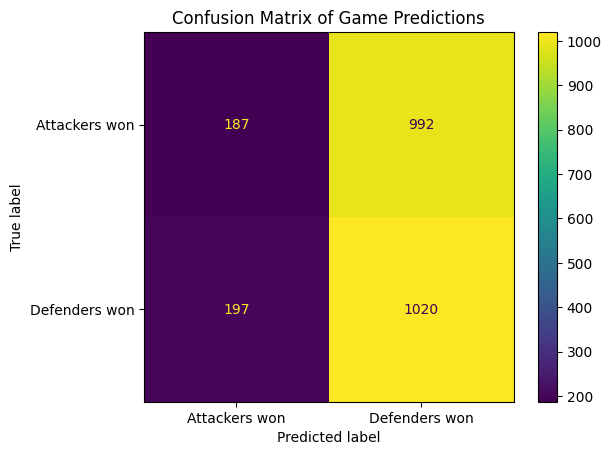

In [10]:

# Credit: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
model = mlflow.sklearn.load_model("/content/DataExplorationR6/mlruns/0/92ecd210ea154a1898feb50e59cf83a5/artifacts/model")

features_train, labels_train, features_validation, labels_validation, features_test, labels_test = split_train_val_test(df)
labels_prediction = model.predict(features_test)
cm = confusion_matrix(labels_test, labels_prediction)

cm_display = ConfusionMatrixDisplay(cm).plot()

plt.title('Confusion Matrix of Game Predictions')
plt.xticks([0, 1], ['Attackers won', 'Defenders won'])
plt.yticks([0, 1], ['Attackers won', 'Defenders won'])
plt.show()


Visualization showing the feature importance determined by the tuned model.

- Overall, the importance of all features in this model are somewhat balanced, there is no one feature that can determine the classification outcome with majority or significance. This reflects the inaccuracy of the model. The model regards all features as similarly unimportant because the model is unable to accurately predict an outcome. It "does not know what it is doing".

- The picked operators are generally more important than the maps and objective locations

- The most important feature (still of little significance) is whether the defenders played the operator "Valkerie". During Season 5, the operator "Valkerie" had an ability that sometimes could never be countered and provides the defenders an unfair advantage over the attackers. This has since been changed.

In [11]:
# Credit: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
importances = model.feature_importances_
features = list(df.columns)
features.pop(0)

df_feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})

df_feature_importance = df_feature_importance[df_feature_importance['Importance'] != 0]
df_feature_importance = df_feature_importance.sort_values('Importance', ascending=False)


fig = px.bar(df_feature_importance, x="Feature", y="Importance", title="Feature Importance of predictions from the tuned DecisonTreeClassifier")

fig.show()
